In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(4235)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


## KNN Classification 
### Predictors: Age, Hours
### Predicting: Subscription

In [3]:
# remove NA values
players <- na.omit(players) 
players$subscribe <- as.factor(players$subscribe)
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


In [4]:
# CHOOSE K VALUE
# split data
players_split <- initial_split(players, prop = 0.7, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [5]:
# find k
knn_spec <- nearest_neighbor(weight = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

player_recipe <- recipe(subscribe ~ Age + played_hours, players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

player_vfold <- vfold_cv(players_training, v = 10, strata = subscribe)

k_vals <- tibble(neighbors = seq(1, 30, 1))

k_val_accuracies <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

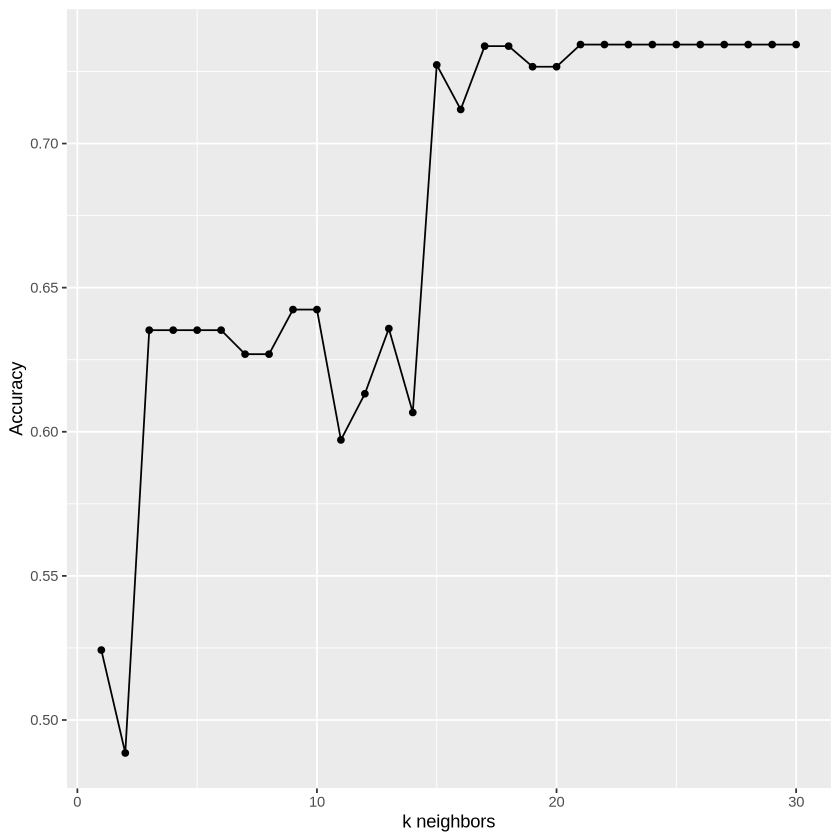

In [7]:
k_accuracy_graph <- ggplot(k_val_accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "k neighbors", y = "Accuracy")

k_accuracy_graph

In [8]:
best_k <- k_val_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

best_k

[1] 21

In [9]:
# find accuracy with test set
knn_spec_best <- nearest_neighbor(weight = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification") 

players_recipe_best <- recipe(subscribe ~ Age + played_hours, players_testing) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_fit <- workflow() |>
    add_recipe(players_recipe_best) |>
    add_model(knn_spec_best) |>
    fit(players_training)

prediction_accuracy <- predict(knn_fit, players_testing) |>
    bind_cols(players_testing) |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull(.estimate)

prediction_accuracy # future predictions should be about this accurate

[1] 0.7288136

In [11]:
# example prediction
# player age 17 with 20 hours played
new_obs <- tibble(Age = 17, played_hours = 20)
predict(knn_fit, new_obs)

.pred_class
<fct>
TRUE


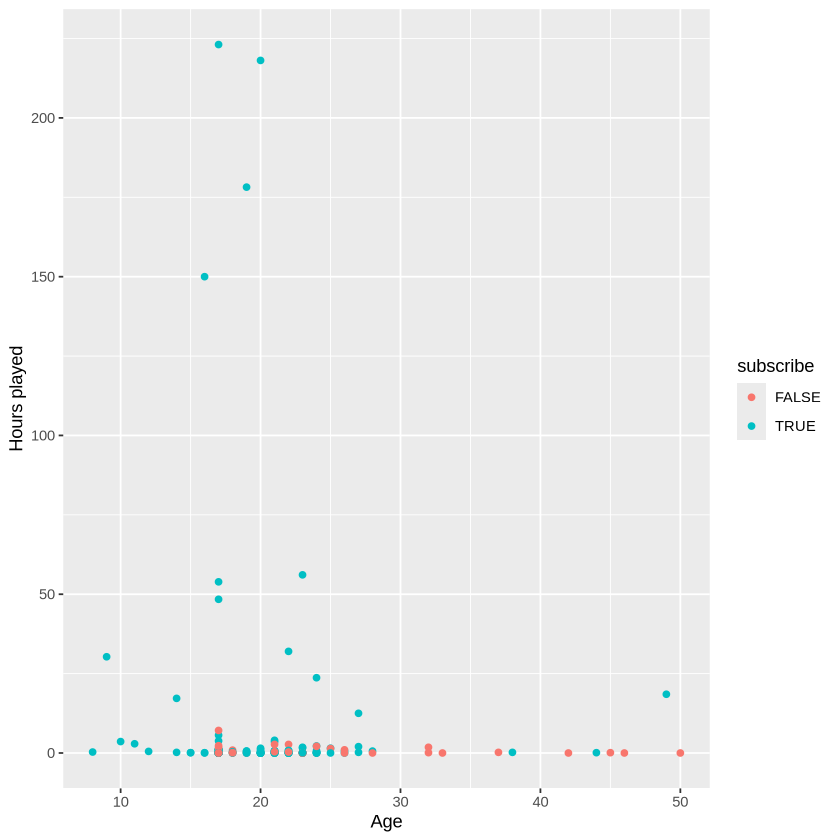

In [16]:
# include some exploratory graphs (ie. some grpahs showing relationship between age, hours played, and subscription)
subs_age_hours <- ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point() + 
    labs(x = "Age", y = "Hours played")

subs_age_hours